# 3.5 Climate Model Data on Google Cloud

The ESGF offers the complete archive of CMIP5, CMIP6, and CORDEX climate model ouput data, but unfortunately it can be prone to errors that can make downloading the data a bit cumbersome. If you're running into difficulties accessing the data using the methods described in Section 3.4, it's worth a try to see if the data you want is available on the Google Cloud Services (GCS) archive of CMIP data, [which you can navigate by following this link](https://console.cloud.google.com/marketplace/product/noaa-public/cmip6). Accessing the data on GCS is similar to using OPeNDAP, in that you can do subsetting on their end, and transfer only the data you want to your own computer for analysis.

The downside of the GCS archive is that it isn't as complete as the ESGF archive. For many models, there is only data at monthly temporal frequency, which isn't so useful for downscaling. Another minor downside is that you'll need to learn a new file format. While netCDF is the standard for climate model output data, GCS uses a cloud-optimized data format called [zarr](https://zarr.dev/). As the focus of scientific computing shifts more and more towards the cloud, zarr has become increasingly popular as the format for climate data hosted on remote servers. Fortunately, `xarray` supports the zarr format, and once you've opened a file with `xr.open_zarr`, you can work with it like you would any other `xr.Dataset` or `xr.DataArray`.

## 3.5.1 Searching For Data

Similar to the ESGF, we can search the GCS climate data catalog in Python to find the files we want. We'll do this using Pandas to access the csv file that contains the data catalog, and then do filtering isolate the access URLs for the desired files.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gcsfs
import zarr

# url for the CSV file that contains the data catalog
url_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

In [2]:
# open the data catalog with pandas, and take a peek at how it's formatted
df_catalog = pd.read_csv(url_catalog)
print(df_catalog.columns)
df_catalog.head()

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version'],
      dtype='object')


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


As you can see, the GCS data catalog is formatted in a very similar way to the ESGF search interface. Each entry in the catalog specifies the:
* Project name (`activity_id`)
* Modeling centre (`institution_id`)
* Model name (`source_id`)
* Experiment type (`experiment_id`, i.e. historical, SSP5-8.5, etc.)
* ID of the ensemble member (`member_id`)
* Time frequency (`table_id`)
* Variable name (`variale_id`)
* Access URL for the Zarr data set(`zstore`)

Plus some other entries we won't worry about for now. You can use the Pandas routine `df.query` to seach for particular values of each column, and return a new DataFrame that contains the entries that meet your search criteria.

For example, let's search for daily precipitation data from the model MPI-ESM1-2-LR for both the historical experiment, and the SSP2-4.5 future scenario.

In [3]:
# prepare the search criteria as a string
search_string = "table_id == 'day' & source_id == 'MPI-ESM1-2-LR' & variable_id == 'pr'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp245']"
df_search = df_catalog.query(search_string)
df_search

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
218364,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r10i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
218552,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r3i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
219088,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r1i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
219697,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r4i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
219930,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r2i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
220123,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r5i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
220331,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r6i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
220638,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r7i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
221400,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r9i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710
221478,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp245,r8i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-...,NaN,20190710


## 3.5.2 Accessing the Data

Excellent, we now have a DataFrame that has the descriptions and access URLs for the datasets we want. In order to access the data, we first need to authenticate ourselves using the `gcsfs` package. Since we're only accessing data available to the public, we can access as an anonymous user.

In [4]:
# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# Get the path to a specific zarr store (the first one from the dataframe above)
zstore_url = df_search.zstore.values[0]
print(zstore_url)

# use the gcfs package to turn the URL into an interface to the data set
mapper = gcs.get_mapper(zstore_url)

# now open the zarr store using xarray. 
# The argument "consolidated" means to include the whole zarr data store for this file
ds = xr.open_zarr(mapper, consolidated = True)
ds

gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/r10i1p1f1/day/pr/gn/v20190710/


<xarray.Dataset>
Dimensions:    (lat: 96, bnds: 2, lon: 192, time: 31411)
Coordinates:
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(15706, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(980, 96, 192), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.5.0
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    tracking_id:            hdl:21.14100/4b1502fc-585a-4005-8d9d-49ad10284480...
    variable_id:            pr
    variant_label:          r10i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/4b1502fc-585a-4005-8d9d-49ad10284480...
    version_id:             v20190710

Here we accessed the data for the SSP2-4.5 scenario, and the ensemble member `r10i1p1f1`. Let's select a spatial region and calculate a long-term average for the period 2071-2100, just to demonstrate that the functionality is the same as before.

In [5]:
# select a region near western Europe
lats = [40, 60]
lons = [-10, 10]

# convert longitude values in the dataset from the (0, 360) convention to the (-180, 180) convention
ds = ds.assign_coords(lon = (((ds.lon + 180) % 360) - 180))
ds = ds.sortby('lon')

# subset the data
ds_subset = ds.sel(lat = slice(*lats), lon = slice(*lons), time = ds.time.dt.year.isin(range(2071, 2101)))
ds_subset

<xarray.Dataset>
Dimensions:    (lat: 11, bnds: 2, lon: 11, time: 10957)
Coordinates:
  * lat        (lat) float64 40.1 41.97 43.83 45.7 ... 53.16 55.02 56.89 58.76
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(11, 2), meta=np.ndarray>
  * lon        (lon) float64 -9.375 -7.5 -5.625 -3.75 ... 3.75 5.625 7.5 9.375
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(11, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 2071-01-01T12:00:00 ... 2100-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(10957, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(126, 11, 11), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.5.0
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    tracking_id:            hdl:21.14100/4b1502fc-585a-4005-8d9d-49ad10284480...
    variable_id:            pr
    variant_label:          r10i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/4b1502fc-585a-4005-8d9d-49ad10284480...
    version_id:             v20190710

In [6]:
# calculate the long-term average precip, and trigger computation
pr_ltm = ds_subset.pr.mean('time').compute() * 86400 # also convert units to mm/day

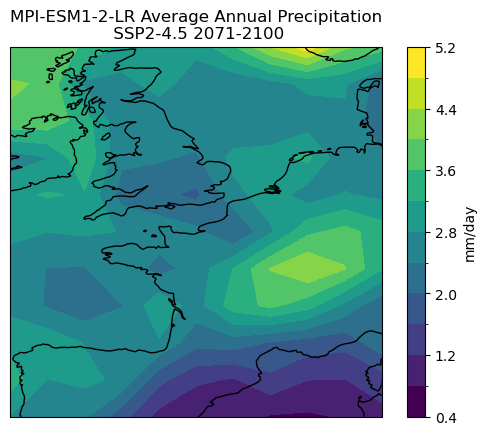

In [7]:
p = pr_ltm.plot.contourf(subplot_kws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree()),
                         levels = 15, cbar_kwargs = dict(label = "mm/day"))
p.axes.coastlines()
p.axes.set_title("MPI-ESM1-2-LR Average Daily Precipitation\n SSP2-4.5 2071-2100")
plt.show()


## 3.5.3 Saving the Data

To save data from Google Cloud to your local machine, you can use either the xarray `to_netcdf` method discussed in the previous section, or save the data in zarr format, just like it is on the cloud. Just like `to_netcdf`, there is a `to_zarr` method for xarray `Dataset` or `DataArray` objects ([documentation here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.to_zarr.html)). The Zarr format doesn't save the data to a single file like netCDF, instead it creates a directory that contains multiple files, each corresponding to different data variables, coordinates, metadata, etc. For most users, there isn't really a benefit of using Zarr versus using netCDF, so it's probably worth keeping it simple and sticking with netCDF as the format of your data files.